**The aim of this exercise is to assess the relationshipt between socio-demographic variables and the rate of physicians per 100k inhabitants at the county level.**

#Imports

In [209]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#Opening Data

In [210]:
link='https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv'
health_raw=pd.read_csv(link)

Data Description: [here](https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/data_dict.csv)

In [211]:
health_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


Data has several variables. First, I will delete the columns that do not add relevant information to the model such as the confidence intervarls (CI):

In [212]:
cols=[s for s in health_raw.columns if 'CI' in s] #List comprenhension extracting CI variables
print(cols)

health_raw.drop(cols, axis=1, inplace=True)

['CI90LBINC_2018', 'CI90UBINC_2018', 'anycondition_Lower 95% CI', 'anycondition_Upper 95% CI', 'Obesity_Lower 95% CI', 'Obesity_Upper 95% CI', 'Heart disease_Lower 95% CI', 'Heart disease_Upper 95% CI', 'COPD_Lower 95% CI', 'COPD_Upper 95% CI', 'diabetes_Lower 95% CI', 'diabetes_Upper 95% CI', 'CKD_Lower 95% CI', 'CKD_Upper 95% CI']


From the data description I can tell there is redundant information. Meaning that there are several variables measuring the same thing (e.g. race is measured as % and also as the total number of people within one category. Same for education, and other variables). Most of the time researchers do not work with absolute numbers (e.g., total population). Instead, they transform those absolute numbers into something else such an index, rate, percentages, standardisation, etc as they are not only easier to work with but also easier for making comparisons and interpreting.

In the following code I delete vabiables that contain absolut numbers for:

*   age groups
*   Duplicated age variables e.g. Population Aged 60+, Percent of Population Aged 60+, county_pop2018_18 and older
*   Variable of total population
*   race/ethnicity
*   Level of education
*   Total number of employed and unemployed people
*   Number of people with a certain health condition



In [213]:
#Obtaining varlist with age groups:
age=[s for s in health_raw.columns if s[0].isdigit() and 'y/o % of total pop' not in s]
print(age)
#list of duplicated age variables & total population variable
double=['Population Aged 60+', 'Percent of Population Aged 60+', 'TOT_POP', 'Total Population','county_pop2018_18 and older']

#Obtaining list of variables of total population by ethnicity:
ethn=[s for s in health_raw.columns if '-alone pop'  in s or 'Two or more races pop' in s]
print(ethn)

#Obtaining list of variables of total population by level of education:
educ=[s for s in health_raw.columns if '2014-18' in s and 'Percent' not in s]
print(educ)

#Total number of employed and unemployed people
emp=[s for s in health_raw.columns if 'mployed_2018' in s and 'rate' not in s]
print(emp)

#Obtaining Number of people with a certain health condition variables
sick=[s for s in health_raw.columns if '_number'in s]
print(sick)

to_drop=age + double+ ethn + educ + emp + sick
print(to_drop)

health_raw.drop(to_drop, axis=1, inplace=True)

['0-9', '19-Oct', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
['White-alone pop', 'Black-alone pop', 'Native American/American Indian-alone pop', 'Asian-alone pop', 'Hawaiian/Pacific Islander-alone pop', 'Two or more races pop']
['Less than a high school diploma 2014-18', 'High school diploma only 2014-18', "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18"]
['Employed_2018', 'Unemployed_2018']
['anycondition_number', 'Obesity_number', 'Heart disease_number', 'COPD_number', 'diabetes_number', 'CKD_number']
['0-9', '19-Oct', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+', 'Population Aged 60+', 'Percent of Population Aged 60+', 'TOT_POP', 'Total Population', 'county_pop2018_18 and older', 'White-alone pop', 'Black-alone pop', 'Native American/American Indian-alone pop', 'Asian-alone pop', 'Hawaiian/Pacific Islander-alone pop', 'Two or more races pop', 'Less than a high school diploma 2014-18', 'High school diploma only 2014-

Narrowed it down to 62 Variables:

In [214]:
health_raw.shape

(3140, 62)

There is no duplicated data:

In [215]:
print(health_raw.duplicated().sum())

0


Apriori there seem to be no missing data:

In [216]:
health_raw.isnull().sum().sort_values(ascending=False)


fips                                                                       0
Total Hospitals (2019)                                                     0
MEDHHINC_2018                                                              0
Civilian_labor_force_2018                                                  0
Unemployment_rate_2018                                                     0
                                                                          ..
Percent of adults with less than a high school diploma 2014-18             0
Percent of adults with a high school diploma only 2014-18                  0
Percent of adults completing some college or associate's degree 2014-18    0
Percent of adults with a bachelor's degree or higher 2014-18               0
Urban_rural_code                                                           0
Length: 62, dtype: int64

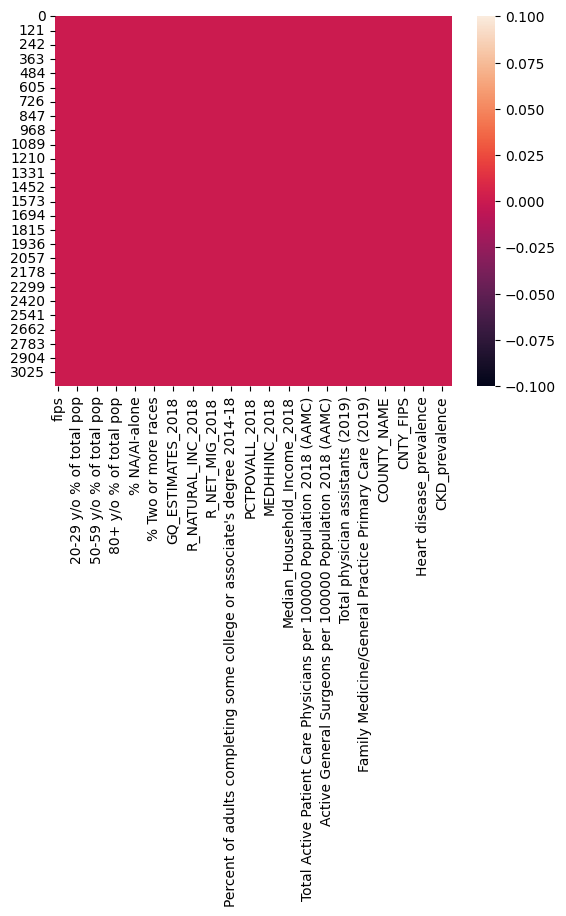

In [217]:
sns.heatmap(health_raw.isnull())
plt.show()

#Exploratory data analysis

In [218]:
health_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
fips,3140.0,30401.640764,15150.559265,1001.000000,18180.500000,29178.000000,45081.500000,5.604500e+04
0-9 y/o % of total pop,3140.0,11.871051,2.124081,0.000000,10.594639,11.802727,12.951840,2.546068e+01
10-19 y/o % of total pop,3140.0,12.694609,1.815044,0.000000,11.674504,12.687422,13.659282,2.330437e+01
20-29 y/o % of total pop,3140.0,12.283979,3.126297,0.000000,10.496774,11.772649,13.182260,3.757020e+01
30-39 y/o % of total pop,3140.0,11.751535,1.696599,6.092789,10.689322,11.580861,12.639379,2.222513e+01
40-49 y/o % of total pop,3140.0,11.556685,1.372935,2.631579,10.685197,11.618372,12.386083,1.943037e+01
50-59 y/o % of total pop,3140.0,13.526733,1.481692,5.316361,12.738561,13.621339,14.429115,2.045455e+01
60-69 y/o % of total pop,3140.0,13.182225,2.532498,3.444403,11.621232,13.013409,14.467254,2.727273e+01
70-79 y/o % of total pop,3140.0,8.399382,2.214915,2.199551,7.032275,8.208162,9.445777,3.132796e+01
80+ y/o % of total pop,3140.0,4.733801,1.535028,0.000000,3.738648,4.565338,5.484143,2.272727e+01


##Overall distribution of the proportion of different age groups:

['0-9 y/o % of total pop', '10-19 y/o % of total pop', '20-29 y/o % of total pop', '30-39 y/o % of total pop', '40-49 y/o % of total pop', '50-59 y/o % of total pop', '60-69 y/o % of total pop', '70-79 y/o % of total pop', '80+ y/o % of total pop']


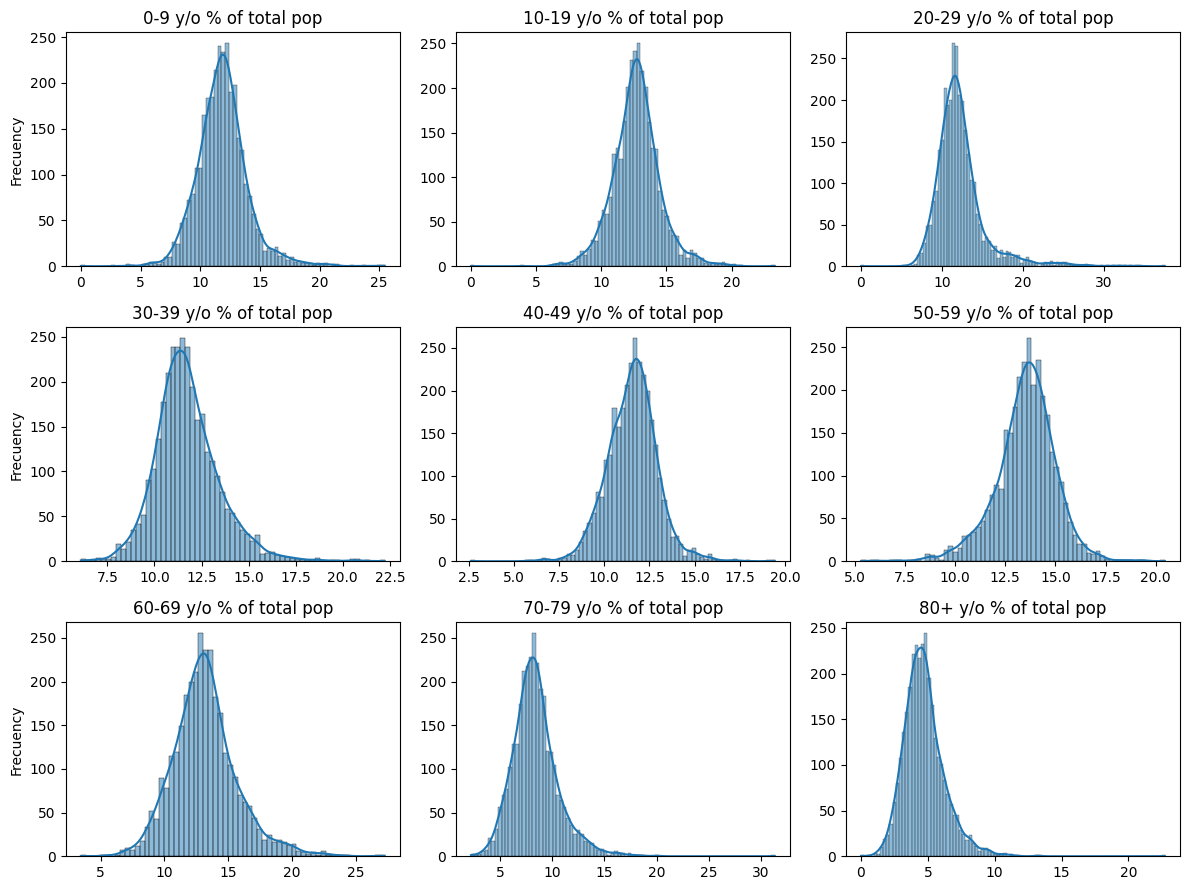

In [219]:
age=[s for s in health_raw.columns if s[0].isdigit()]
print(age)

cols=3
rows=((len(age) - 1) // cols) + 1
fig, axis = plt.subplots(rows, cols, figsize=(12, rows * 3))

for col, ax in zip(age, axis.flatten()):
  sns.histplot(health_raw[col], kde=True, ax=ax)
  ax.set_title(col)
  ax.set_ylabel('')
  ax.set_xlabel('')

axis[0,0].set_ylabel('Frecuency')
axis[1,0].set_ylabel('Frecuency')
axis[2,0].set_ylabel('Frecuency')

#removing empty subplots
for i in range(len(age), len(axis.flatten())):
      fig.delaxes(axis.flatten()[i])

plt.tight_layout()
plt.show()

##Overall distribution of the proportion of different ethnicities:

There seem to be outliers for native american, asian and hawaian

['% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', '% Hawaiian/PI-alone', '% Two or more races']


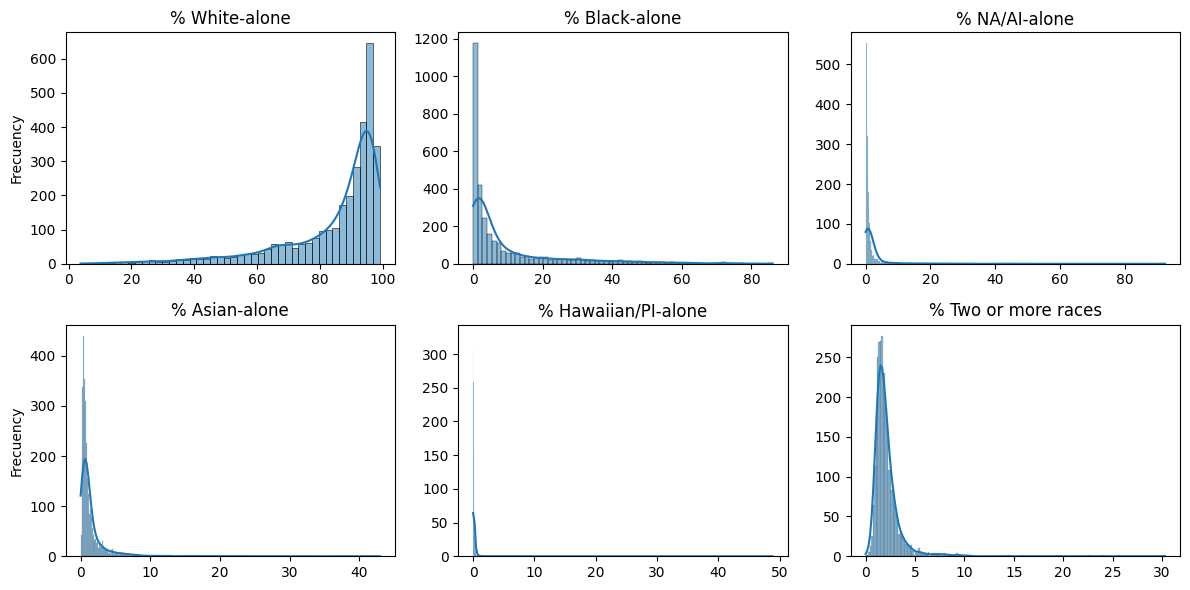

In [220]:
ethn=[s for s in health_raw.columns if '-alone'  in s or '% Two or more races' in s]
print(ethn)

cols=3
rows=((len(ethn) - 1) // cols) + 1
fig, axis = plt.subplots(rows, cols, figsize=(12, rows * 3))

for col, ax in zip(ethn, axis.flatten()):
  sns.histplot(health_raw[col], kde=True, ax=ax)
  ax.set_title(col)
  ax.set_ylabel('')
  ax.set_xlabel('')

axis[0,0].set_ylabel('Frecuency')
axis[1,0].set_ylabel('Frecuency')


#removing empty subplots
for i in range(len(ethn), len(axis.flatten())):
      fig.delaxes(axis.flatten()[i])

plt.tight_layout()
plt.show()

##Distribution of healthcare staff/facilities variables

###Histograms

13
['Active Physicians per 100000 Population 2018 (AAMC)', 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)', 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)', 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)', 'Active General Surgeons per 100000 Population 2018 (AAMC)', 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)', 'Total nurse practitioners (2019)', 'Total physician assistants (2019)', 'Total Hospitals (2019)', 'Internal Medicine Primary Care (2019)', 'Family Medicine/General Practice Primary Care (2019)', 'Total Specialist Physicians (2019)', 'ICU Beds_x']


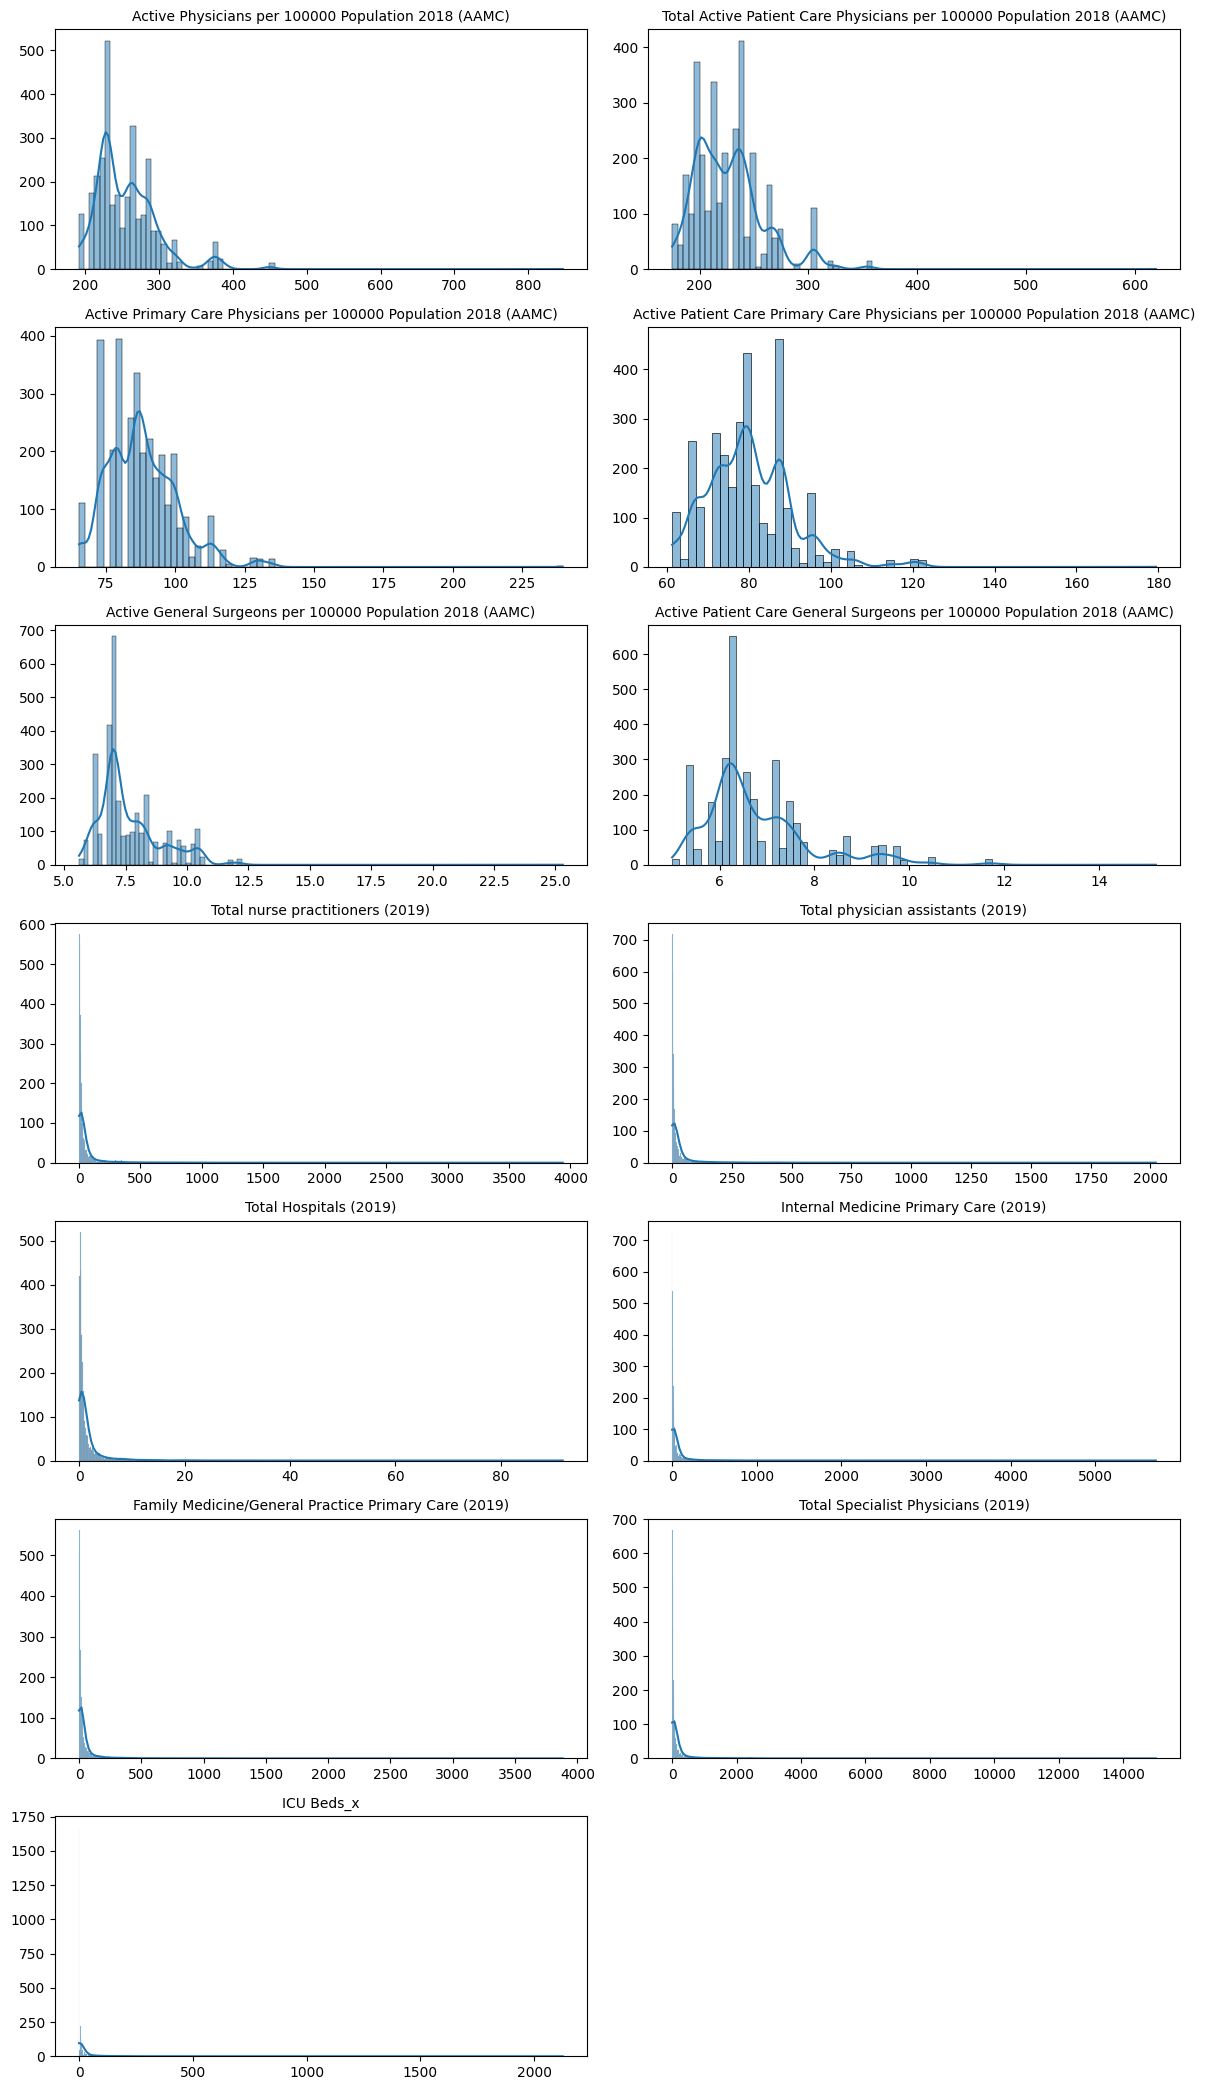

In [221]:
med=[s for s in health_raw.columns if 'Active'  in s or 'Total ' in s or 'Medicine' in s or 'ICU' in s]
print(len(med))
print(med)

cols=2
rows=((len(med) - 1) // cols) + 1
fig, axis = plt.subplots(rows, cols, figsize=(12, rows * 3))

for col, ax in zip(med, axis.flatten()):
  sns.histplot(health_raw[col], kde=True, ax=ax)
  ax.set_title(col, fontsize=10)
  ax.set_ylabel('')
  ax.set_xlabel('')

# axis[0,0].set_ylabel('Frecuency')
# axis[1,0].set_ylabel('Frecuency')


#removing empty subplots
for i in range(len(med), len(axis.flatten())):
      fig.delaxes(axis.flatten()[i])

plt.tight_layout()
plt.show()

###Correlations

As expected, health staff/resources variables are highly correlated which may lead to imperfect multicollinearity if these variables are included on the linear regression as explanatory variables.

For the purpose of this exercise, all these variables will remain in the database. I expect that they will harm the performance of the linear regression and that the lasso regression will be able to pick up the collinear covariates and set their coefficients equal to zero

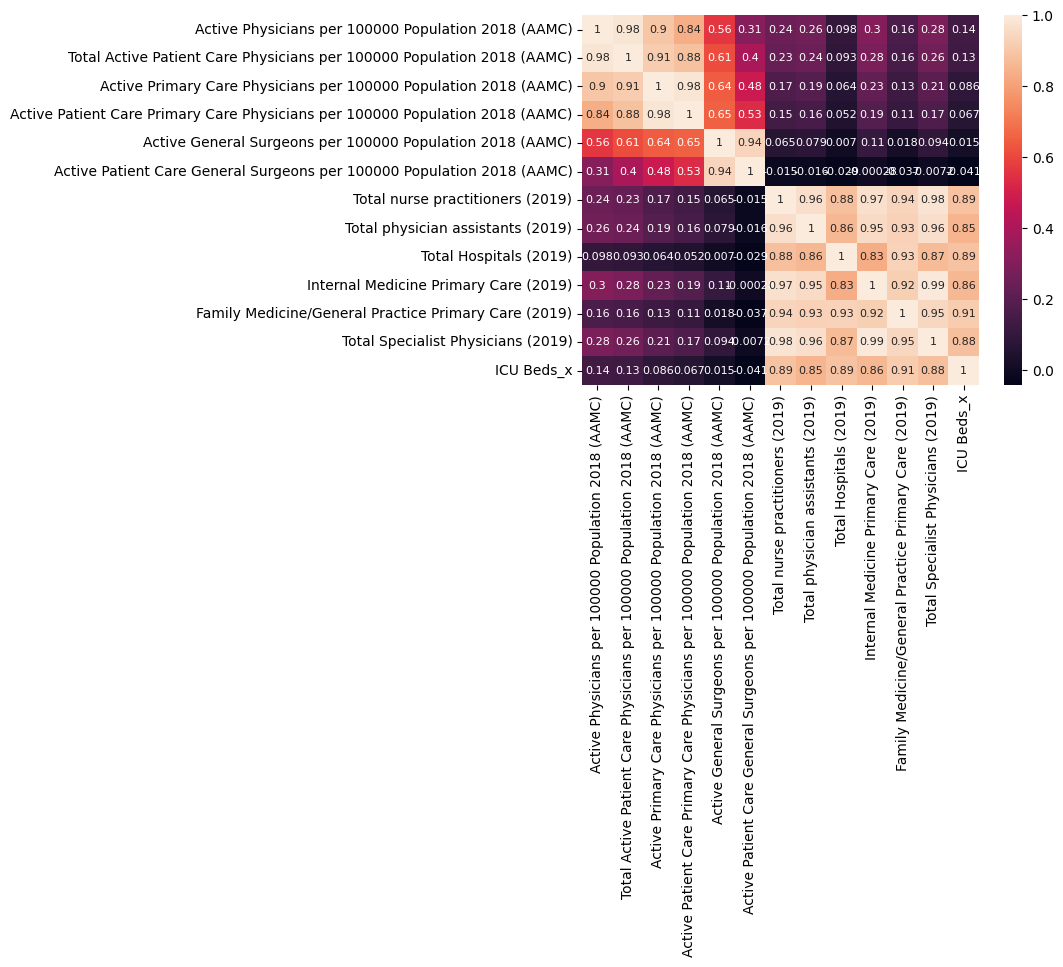

In [222]:
sns.heatmap(health_raw[med].corr(), annot=True, annot_kws={'fontsize':8})
plt.show()

##Dsitributions of prevalence of health conditions

6
['Active Physicians per 100000 Population 2018 (AAMC)', 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)', 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)', 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)', 'Active General Surgeons per 100000 Population 2018 (AAMC)', 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)', 'Total nurse practitioners (2019)', 'Total physician assistants (2019)', 'Total Hospitals (2019)', 'Internal Medicine Primary Care (2019)', 'Family Medicine/General Practice Primary Care (2019)', 'Total Specialist Physicians (2019)', 'ICU Beds_x']


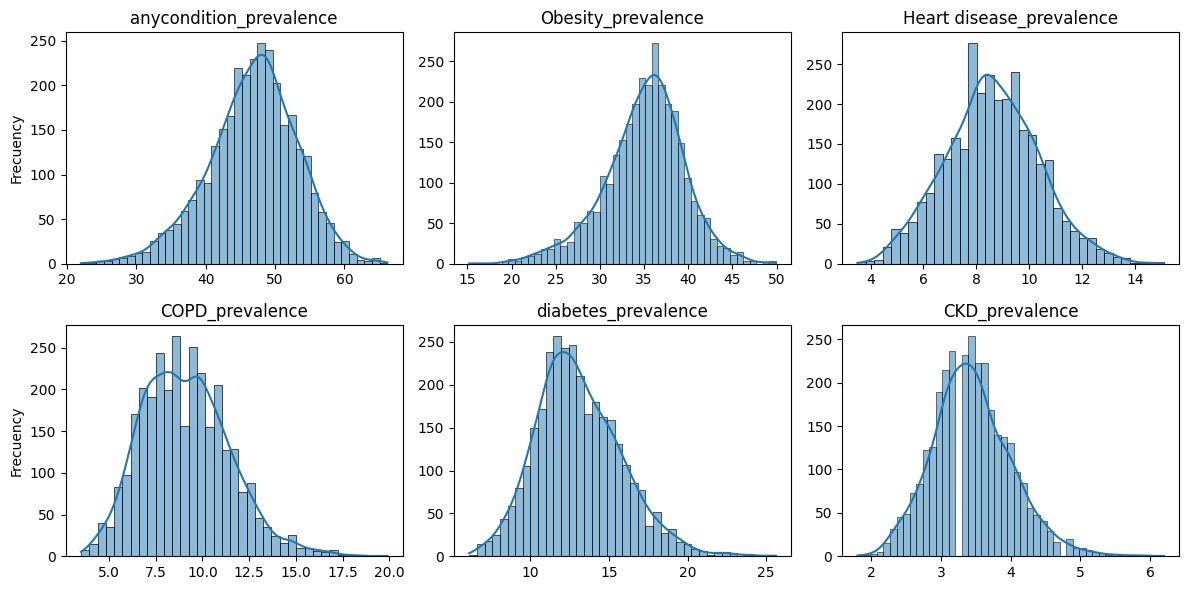

In [223]:
sick=[s for s in health_raw.columns if '_prevalence'  in s]
print(len(sick))
print(med)

cols=3
rows=((len(sick) - 1) // cols) + 1
fig, axis = plt.subplots(rows, cols, figsize=(12, rows * 3))

for col, ax in zip(sick, axis.flatten()):
  sns.histplot(health_raw[col], kde=True, ax=ax)
  ax.set_title(col)
  ax.set_ylabel('')
  ax.set_xlabel('')

axis[0,0].set_ylabel('Frecuency')
axis[1,0].set_ylabel('Frecuency')


#removing empty subplots
for i in range(len(sick), len(axis.flatten())):
      fig.delaxes(axis.flatten()[i])

plt.tight_layout()
plt.show()

##Relationship between health conditions and physicians per 100k population:

Extreme value detected for the dependent variable physicians per 100k population

['% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', '% Hawaiian/PI-alone', '% Two or more races', '0-9 y/o % of total pop', '10-19 y/o % of total pop', '20-29 y/o % of total pop', '30-39 y/o % of total pop', '40-49 y/o % of total pop', '50-59 y/o % of total pop', '60-69 y/o % of total pop', '70-79 y/o % of total pop', '80+ y/o % of total pop', 'Active Physicians per 100000 Population 2018 (AAMC)']


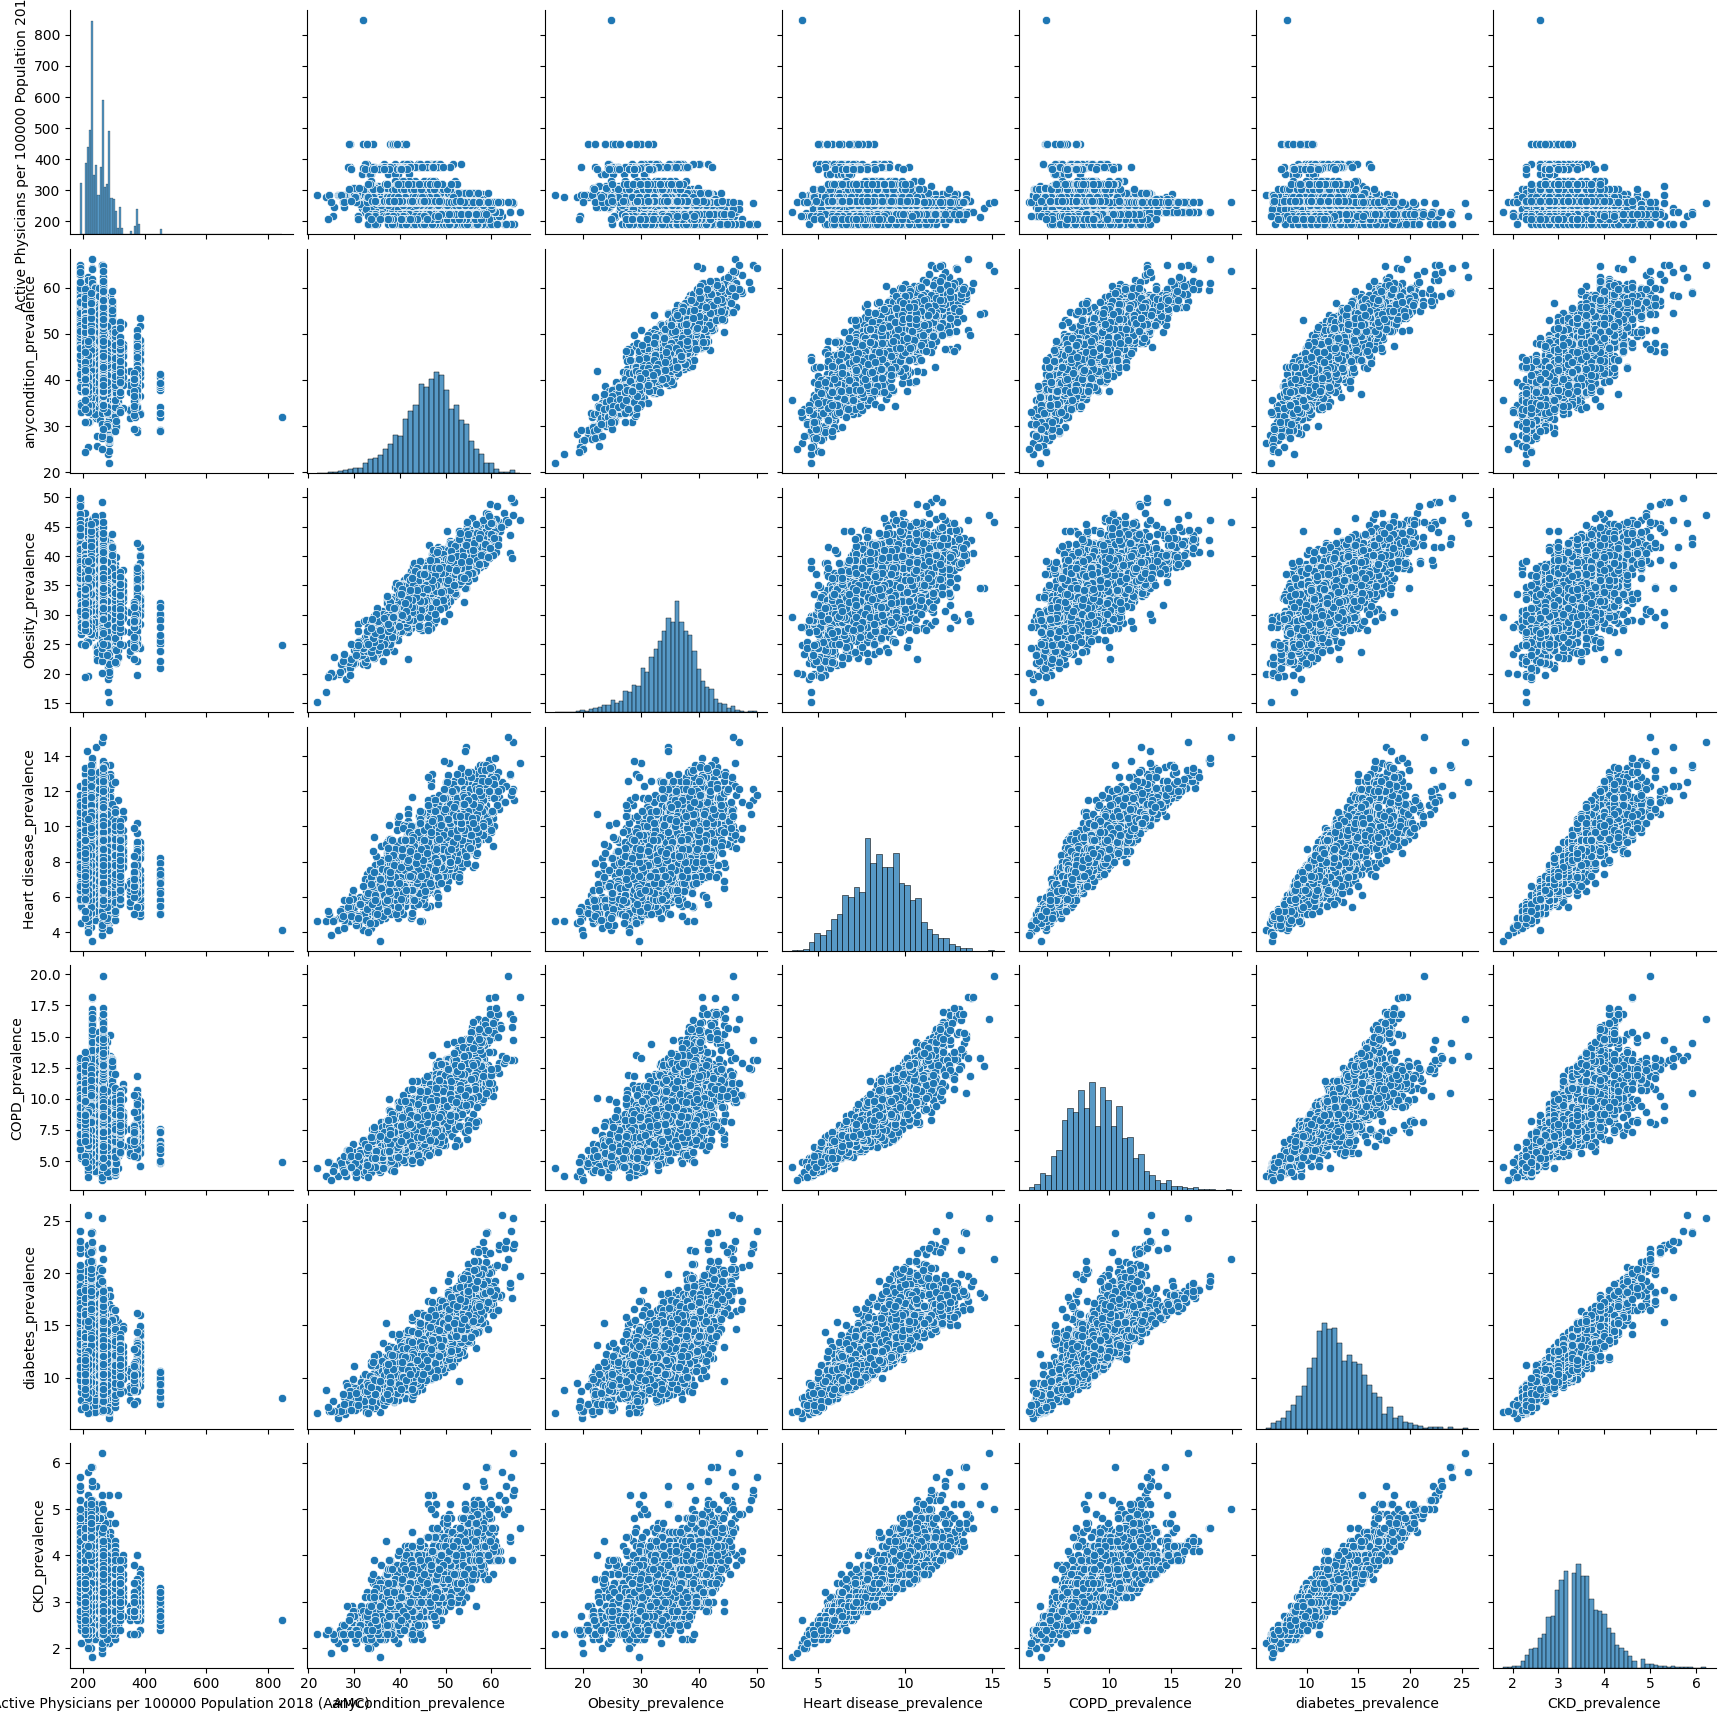

In [224]:
c=ethn+age+[med[0]]
print(c)
sns.pairplot(health_raw[[med[0]]+sick], corner=False)
plt.show()

**Removing extreme values:**

There is only one extreme value to remove

In [225]:
condition=health_raw['Active Physicians per 100000 Population 2018 (AAMC)']>600
health_raw[condition]['Active Physicians per 100000 Population 2018 (AAMC)'].value_counts()
health_raw.drop(health_raw[condition].index, inplace=True)

#Statistical modelling

The aim of this model is to assess the relationshipt between socio-demographic variables and the rate of physicians per 100k inhabitants at the county level.

To accomplish this task, first, I will estimate a linear regression without using feature selection and compare its performance with a lasso regression

#Final steps before splitting data

First, I will remove ID variables that will not be used such as: fips, COUNTY_NAME, STATE_FIPS, CNTY_FIPS

In [226]:
health_raw.drop(['fips', 'COUNTY_NAME', 'STATE_FIPS', 'CNTY_FIPS'], inplace=True, axis=1)

Next, I will add dummy/binary variables for each state to account for the fact that demographic and health-related observations within each state are correlated since counties belonging to a given state share similar culture, environment and laws.

In [227]:
health_raw=pd.get_dummies(health_raw, columns=['STATE_NAME'], prefix='STATE_NAME', drop_first=True)

Now the data has 106 columns that include the roughly 50+ US states and territories

In [228]:
health_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3139 entries, 0 to 3139
Columns: 106 entries, 0-9 y/o % of total pop to STATE_NAME_Wyoming
dtypes: float64(48), int64(9), uint8(49)
memory usage: 1.5 MB


##Splitting data

In [229]:
X=health_raw.drop('Active Physicians per 100000 Population 2018 (AAMC)', axis=1)
y=health_raw['Active Physicians per 100000 Population 2018 (AAMC)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Data scaling

In [230]:
scaler=StandardScaler()
scaler.fit(X_train)

X_train=pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test=pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

##Linear regression

In [231]:
linreg=LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

###Evaluating model performance on ***train*** data:

In [232]:
y_train_pred=linreg.predict(X_train)

On the training set, the explanatory variables explain 100% of the variance in the number of Active Physicians per 100000 Population.

The root-mean squared error, on the training model, on average the model's predictions differ from the actual values by approximately 1.2 Physicians per 100000 Population.

Although once could argue the model did a great job with the train data, in practice, it is not common to obtain an R-squared of 100%. Especially when I pointed out earlier that the model suffers from imperfect multicollinearity.

Having imperfect multicollinearity can lead to serious consecuences on the estimates since they would have a higher variance. The estimates also becomre more sensitive to changes in the sample, which affects the external validity of the model when generalising it to new data.

High imperfect multicollinearity can lead to higher overfitting and to an  inflated R-squared, mening that the independet variables falsely predict a higher percentage of the variance in the dependent variable. In reality, what occurs is that this falsely high explanatory power is due to correlated covariates.

In [233]:
print('R-squared: ', linreg.score(X_train, y_train))
print('Root-Mean squared error: ', mean_squared_error(y_train, y_train_pred, squared=False))

R-squared:  1.0
Root-Mean squared error:  1.257507804138401e-13


###Evaluating model performance on ***test*** data:

As metioned earlier, the model does not provide reliable results.

In [234]:
y_test_pred=linreg.predict(X_test)

In [235]:
print('R-squared: ', linreg.score(X_test,y_test))
print('Root-Mean squared error: ', mean_squared_error(y_test, y_test_pred, squared=False))

R-squared:  1.0
Root-Mean squared error:  1.3824070340036057e-13


##Lasso Regression

In [236]:
alphas={'alpha':np.linspace(0,20,40)}
lasso=Lasso()
score={'R-Square':'r2', 'Root-MSE': 'neg_root_mean_squared_error'}

#Train data
lasso_cv=GridSearchCV(lasso, alphas, scoring=score, refit=False) #setting refit=False as the aim is to see how the metrics change with alpha, not refitting the
lasso_cv.fit(X_train, y_train)
metrics_train=pd.DataFrame(lasso_cv.cv_results_)

metrics_train['mean_test_Root-MSE']=-metrics_train['mean_test_Root-MSE']#gridsearch sets MSE with negative values by default
to_rename = {'mean_test_R-Square': 'mean_train_R-Square',
    'mean_test_Root-MSE': 'mean_train_Root-MSE',}

metrics_train.rename(columns=to_rename, inplace=True)# Rename the columns

#Test Data
lasso_cv.fit(X_test, y_test)
metrics_test=pd.DataFrame(lasso_cv.cv_results_)

metrics_test['mean_test_Root-MSE']=-metrics_test['mean_test_Root-MSE']#gridsearch sets MSE with negative values by default


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/pytho

In [237]:
metrics_train.info()
#metrics_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean_fit_time         40 non-null     float64
 1   std_fit_time          40 non-null     float64
 2   mean_score_time       40 non-null     float64
 3   std_score_time        40 non-null     float64
 4   param_alpha           40 non-null     object 
 5   params                40 non-null     object 
 6   split0_test_R-Square  40 non-null     float64
 7   split1_test_R-Square  40 non-null     float64
 8   split2_test_R-Square  40 non-null     float64
 9   split3_test_R-Square  40 non-null     float64
 10  split4_test_R-Square  40 non-null     float64
 11  mean_train_R-Square   40 non-null     float64
 12  std_test_R-Square     40 non-null     float64
 13  rank_test_R-Square    40 non-null     int32  
 14  split0_test_Root-MSE  40 non-null     float64
 15  split1_test_Root-MSE  40 

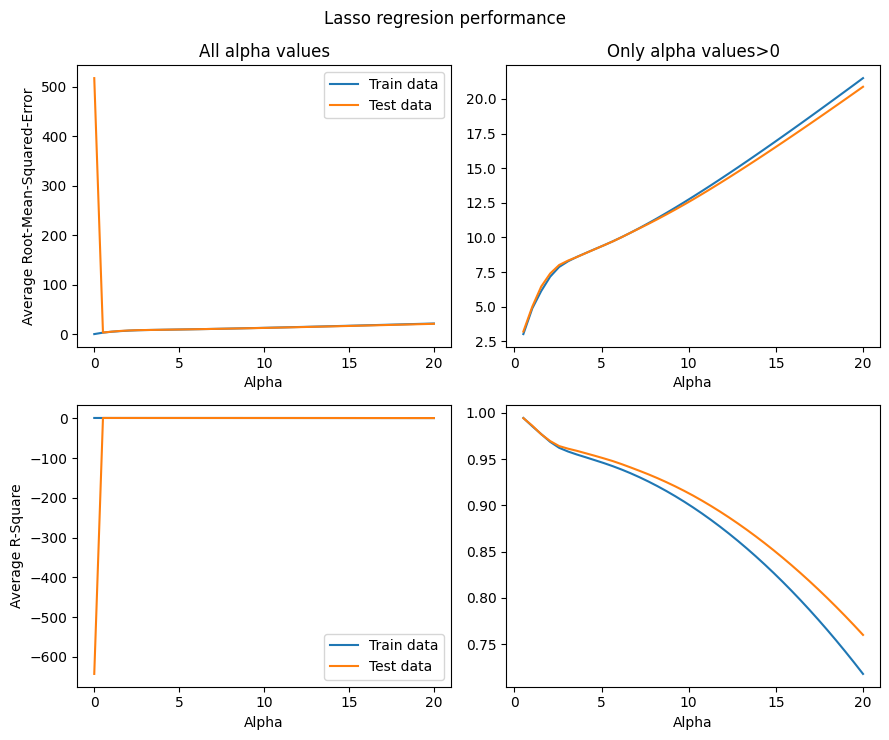

In [238]:
fig, ax = plt.subplots(2,2, figsize=(9,7.5))

ax[0,0].plot(metrics_train['param_alpha'], metrics_train['mean_train_Root-MSE'], label='Train data')
ax[0,0].plot( metrics_test['param_alpha'], metrics_test['mean_test_Root-MSE'], label='Test data')
ax[0,0].set_ylabel('Average Root-Mean-Squared-Error')
ax[0,0].set_xlabel('Alpha')
ax[0,0].set_title('All alpha values')
ax[0,0].legend()

ctrain=metrics_train['param_alpha']>0
ctest=metrics_test['param_alpha']>0
ax[0,1].plot(metrics_train[ctrain]['param_alpha'], metrics_train[ctrain]['mean_train_Root-MSE'])
ax[0,1].plot(metrics_test[ctest]['param_alpha'], metrics_test[ctest]['mean_test_Root-MSE'])
ax[0,1].set_xlabel('Alpha')
ax[0,1].set_title('Only alpha values>0')

ax[1,0].plot(metrics_train['param_alpha'], metrics_train['mean_train_R-Square'], label='Train data')
ax[1,0].plot( metrics_test['param_alpha'], metrics_test['mean_test_R-Square'], label='Test data')
ax[1,0].set_ylabel('Average R-Square')
ax[1,0].set_xlabel('Alpha')
ax[1,0].legend()

ax[1,1].plot(metrics_train[ctrain]['param_alpha'], metrics_train[ctrain]['mean_train_R-Square'])
ax[1,1].plot(metrics_test[ctest]['param_alpha'], metrics_test[ctest]['mean_test_R-Square'])
ax[1,1].set_xlabel('Alpha')


plt.suptitle('Lasso regresion performance')
plt.tight_layout()
plt.show()

Based on the previous graphs, the Root-MSE and R-square shows a big jump on the test data when alpha=0. This result is expected given the imperfect multicollinearity issue described above

Between alpha values greater than zero and up to roughtly 2.5, both, train and test models, show similar performance on the Root-MSE and the R-square

For alpha values higher than 2.5, the test model shows a lower root-MSE and a higher R-square relative to the train model. Suggesting that the test model has a better performance.

###Best hyperparameters

Given the previous graphs, I exclude the alpha value of zero as it does not do any adjustment to the coefficients.

Below is the best hyperparameter where both ranking scores for Root-MSE and R-square is equal to 2, meaning that it is the second best alpha. The first one is alpha = 0, which is excluded.

In [239]:
print(metrics_train[ctrain][['param_alpha','rank_test_Root-MSE','rank_test_R-Square']].head())

best_alpha=metrics_train[metrics_train['rank_test_Root-MSE']==2][['param_alpha']]
best_alpha=float(best_alpha.iloc[0,0])


  param_alpha  rank_test_Root-MSE  rank_test_R-Square
1    0.512821                   2                   2
2    1.025641                   3                   3
3    1.538462                   4                   4
4    2.051282                   5                   5
5    2.564103                   6                   6


In [240]:
lasso=Lasso(alpha=best_alpha, max_iter = 300)
lasso.fit(X_train, y_train)

y_test_pred=lasso.predict(X_test)

print('R-squared: ', lasso.score(X_test,y_test))
print('Root-Mean squared error: ', mean_squared_error(y_test, y_test_pred, squared=False))



R-squared:  0.995424245568743
Root-Mean squared error:  2.89322669130144
